# Industry Accelerators - Financial Markets Customer Attrition Prediction Model

## Introduction

In this notebook we will be going through an end-to-end project to load the prepped data, build some machine learning models, and then deploy those built models. This model predicts how likely the Attrition will occur in the life of a client within a certain period of time in the future (Forecast Horizon). Attrition is defined by the client being inactive or the value of the client's Assets Under Management (AUM) drops by a certain percentage over the period of a month. This model allows the organization to identify the clients who have a high likelihood of leaving or transferring their assets to another firm within a certain period of time. The model does this by tracking seasonality trends. The summary and demographic information is analyzed at a client level. 

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 1000)

import importlib
import warnings
import sys
import time
import os
import pickle 
import project_lib
import random
import string

project = project_lib.Project() 
warnings.filterwarnings('ignore')

np.random.seed(0)

#### Load the prepped data 
Read the data that was prepared in the previous notebook

In [2]:
prepped_data_file = project.get_file("training_data.csv")
prepped_data_file.seek(0)

df_prepped = pd.read_csv(prepped_data_file)               

### Splitting the Data

We set up our feature inputs and our outcome variable also called the $X$ and $y$ values. Our $X$ values will be the features we use in our model while $y$ is the output or what we'll try and predict. After we set up the appropriate $X$ and $y$ values then we split our data into train and test data sets using a common 80:20 split with 80% of the data being used for training our model and 20% being held out to test or validate our model.

When we split our datset we want to do a stratified sampling using our outcome variable with the `stratify=y_output` parameter. This ensures that when we split our dataset we maintain the proportions or balance of the outcome variable, `y_output`, from the original dataset to within both train and test datasets.

Finally, we set the seed using `random_state=1234` parameter for reproducibility purposes.

In [3]:
from sklearn.model_selection import train_test_split

X_inputs = df_prepped.drop(['TARGET'], axis=1)
y_output = df_prepped['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X_inputs, y_output, stratify=y_output,
                                                    test_size=0.20, random_state=1234)

print("Train and Test Data Dimensions:")
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))
print("X_test shape:  {}".format(X_test.shape))
print("y_test shape:  {}".format(y_test.shape))

Train and Test Data Dimensions:
X_train shape: (576, 33)
y_train shape: (576,)
X_test shape:  (145, 33)
y_test shape:  (145,)


## Building Machine Learning Models
 The final phase, and the most fun part, is the modeling. We'll train and validate 3 types of models:<br>
 1. Logistic Regression
 2. Random Forests
 3. Gradient Boosting for Classification
 
For each of these models we'll fit our model and test the model showing accuracy metrics for both the training and testing data. Then we'll look at the confusion matrices, for both train and test data, to see where the model is classifying best across the binary labels. Finally for the random forests and the gradient boosting models we'll look at the variable importance plots. Let's take a look at training these models and their accuracies.

### Model Fitting
First step is to build the classifier and then fit a classifier on your $X$ and $y$ training data for our datasets. Let's fit the 3 models mentioned above.

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Logistic Regression, Random Forest, and Gradient Boost
lr_model = LogisticRegression(penalty='l1', solver='saga', tol=0.1).fit(X_train, y_train)
rf_model = RandomForestClassifier(n_estimators=500, max_depth=9, random_state=1234).fit(X_train, y_train)
gb_model = GradientBoostingClassifier(learning_rate=0.01, n_estimators=500, max_depth=12, random_state=1234).fit(X_train, y_train)

models = {"Logistic Regression": lr_model,
          "Random Forest": rf_model,
          "Gradient Boosting": gb_model}

### Plot Confusion Matrices

We want to see where the model is misclassifying across our binary labels. For that we'll look at our confusion matrix.

**`plot_confusion_matrix`**: This function plots an annotated and more presentable confusion matrix for the classification model results

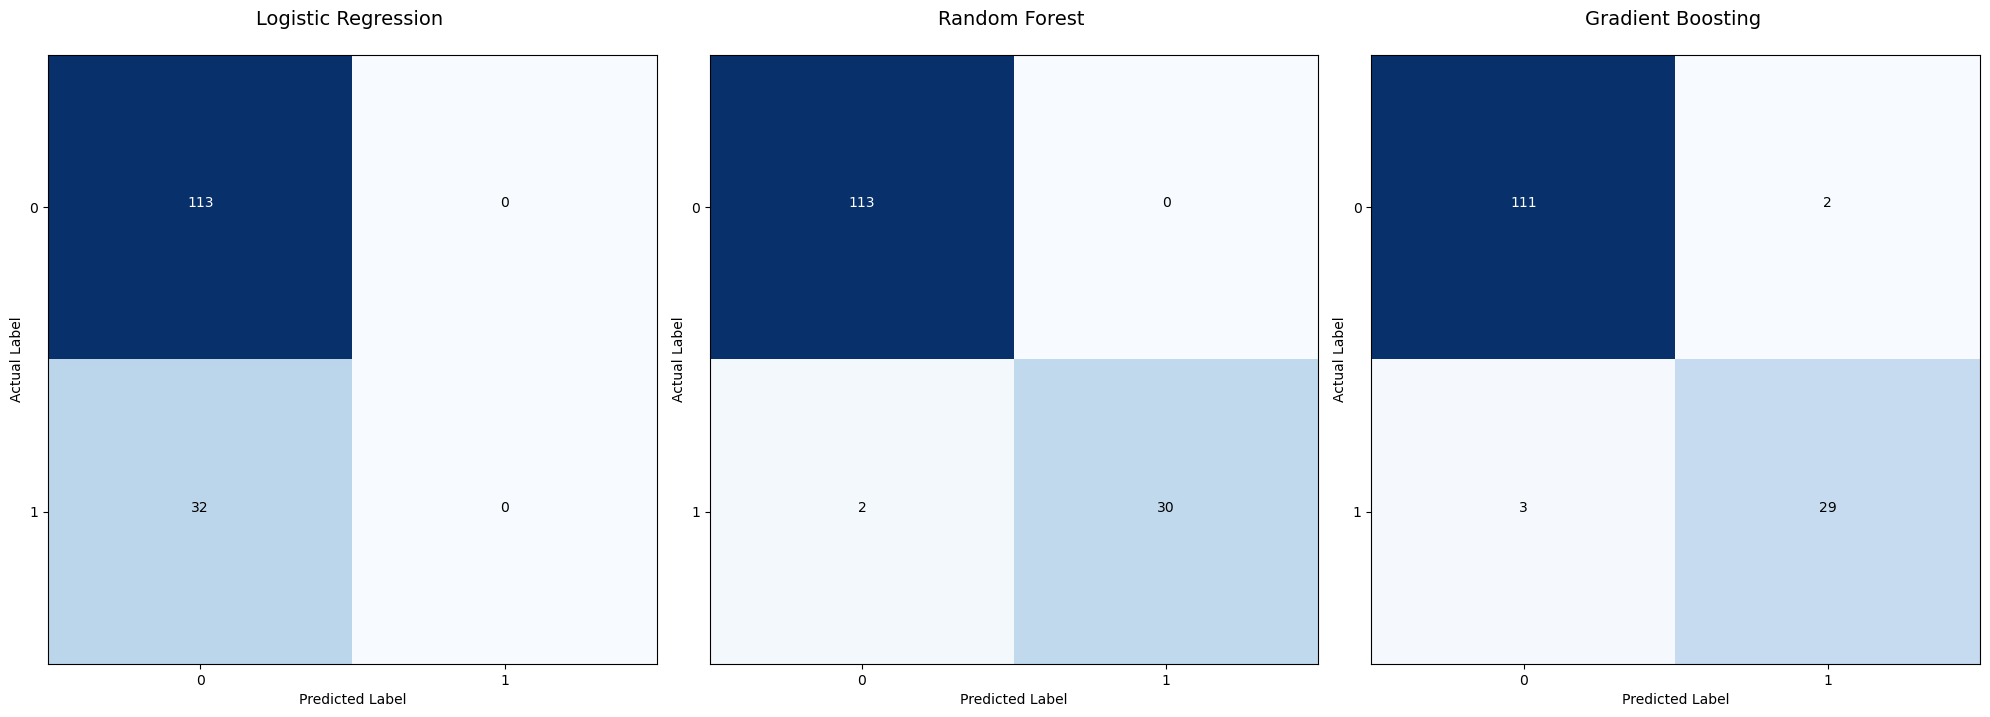

In [5]:
from sklearn import metrics
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    Function to plot the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

# Iterate over model types, calculating and then plotting confusion matrices
fig  = plt.figure(figsize=(20,10))
plot = 1

for model_type, model in models.items():
    y_pred_test = model.predict(X_test)
    confusion_matrix = metrics.confusion_matrix(y_test, y_pred_test, labels=[0,1])

    fig.add_subplot(130+plot)
    plot_confusion_matrix(confusion_matrix, normalize=False, classes=['0','1'], title=model_type+' \n')
    plot += 1

### View Model Test Accuracies

There are several metrics of model performance that we can check. For this project, we choose to view the model accuracy.

In [6]:
acc = pd.DataFrame(columns = ['Type', 'accuracy'])
for model_type, model in models.items():
    acc = acc.append({'Type': model_type, 'accuracy': round(model.score(X_test, y_test),4)}, ignore_index=True)
acc.set_index('Type',inplace=True)

print("\nModel Test Accuracy : ")
acc


Model Test Accuracy : 


,accuracy
Type,
Logistic Regression,0.7793
Random Forest,0.9862
Gradient Boosting,0.9655


The Random Forest model has the highest performance, so we select that model to move forward with.

### Plot Feature Importance

With tree based models you can view variable importance plots. These plots indicate, at the feature level, some importance for the variable to classify the outcome variable. It uses gini importance (mean decrease in impurity) which looks at node impurity. Node impurity is just looking at how well a tree splits the data. Technically it calculates each feature importance as the sum over the number of splits that include the feature, proportionally to the number of samples it splits.

We'll take a look at the feature importance plots for the best performing models. The top models in terms of accuracy were random forest and gradient boosting.

**`plot_feature_importance`**: This plots an annotated and more presentable variable importance plot for the top 10 variables.

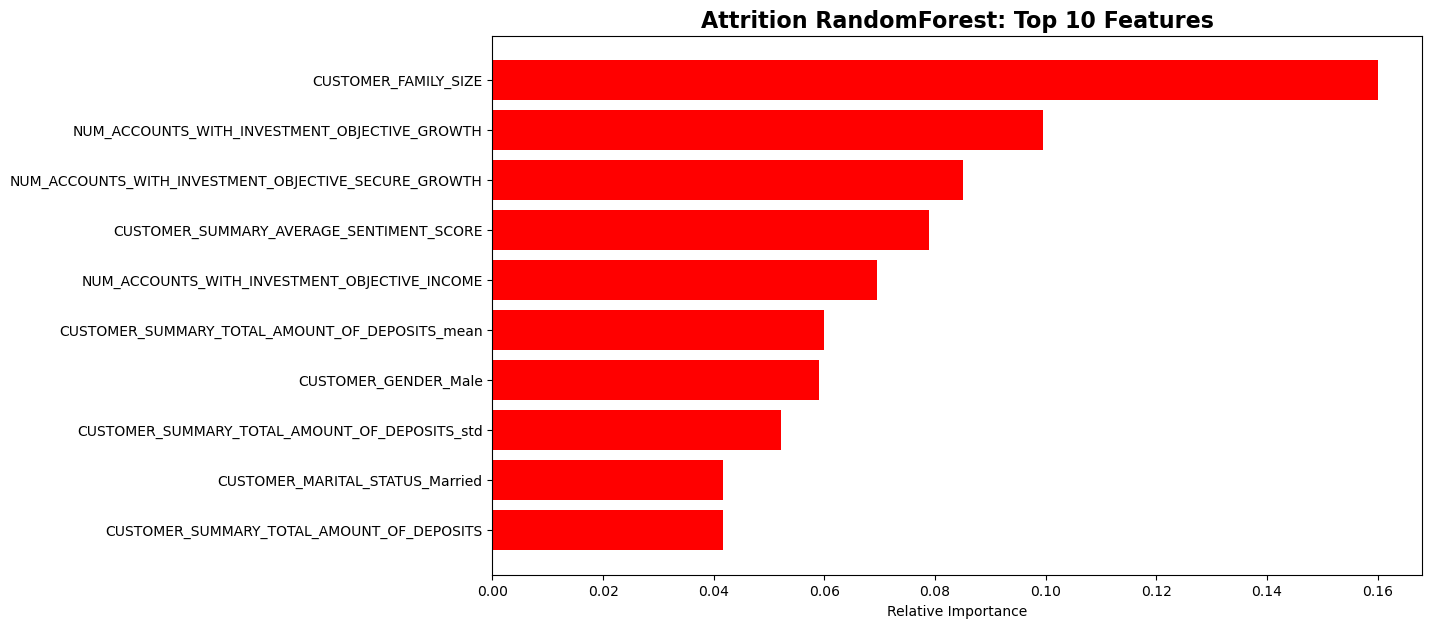

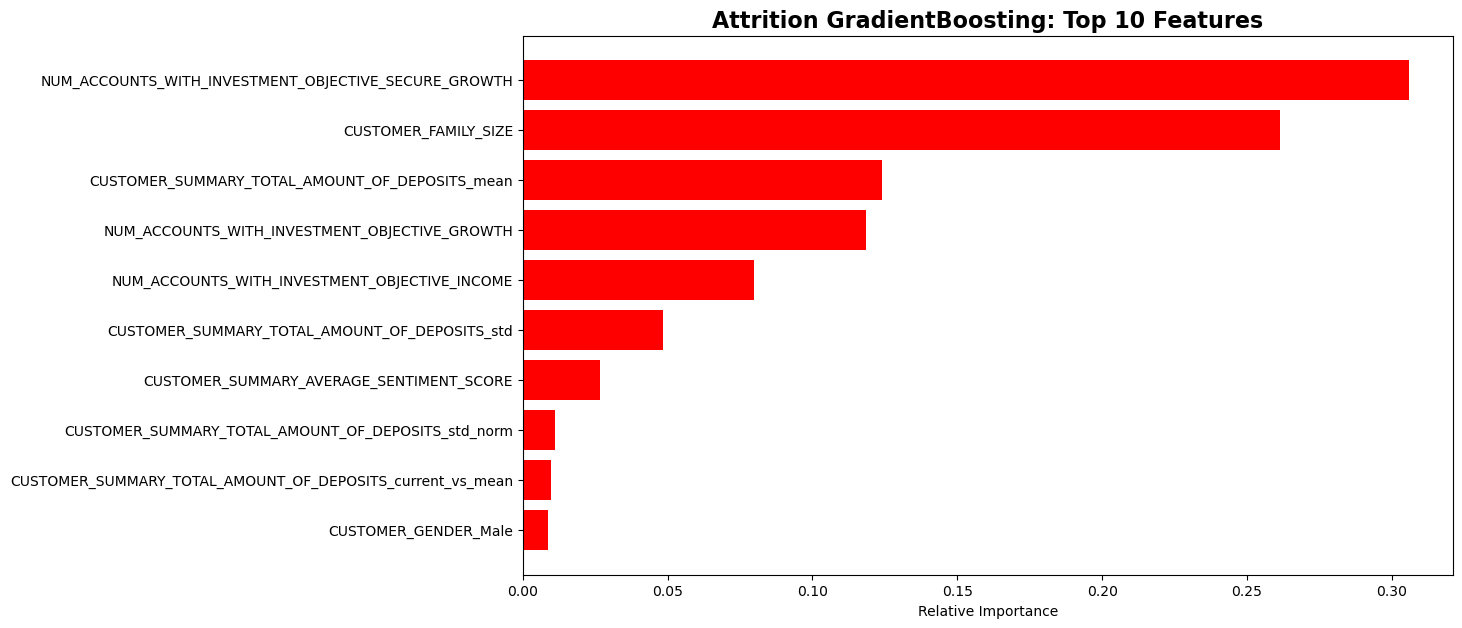

In [7]:
def plot_feature_importance(feature_list, feature_importances, title='Feature Importance Plot'):
    """
    Function to Plot Feature Importances
    """
    features = feature_list
    importances = feature_importances
    indices = np.argsort(importances)[-10:]
    
    plt.figure(figsize=(12,7))
    plt.title(title, fontsize=16, fontweight='bold')
    plt.barh(range(len(indices)), importances[indices], color='r', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    

# show feature importances of RandomForest and GradientBoost models
plot_feature_importance(feature_list=X_train.columns.tolist(), 
                        feature_importances=models['Random Forest'].feature_importances_, 
                        title="Attrition RandomForest: Top 10 Features")
plot_feature_importance(feature_list=X_train.columns.tolist(), 
                        feature_importances=models['Gradient Boosting'].feature_importances_, 
                        title="Attrition GradientBoosting: Top 10 Features")

## Save the best classification model to Cloud Pak for Data

As it is the top performing model, we select the Random Forest model for scoring new data. In the next steps we save and deploy the model.

Before we save the model we must create a deployment space. Watson Machine Learning provides deployment spaces where the user can save, configure and deploy their models. We can save models, functions and data assets in this space.

The steps involved in saving and deploying the pipeline are detailed in the following cells. We will use the [ibm-watson-machine-learning](http://ibm-wml-api-pyclient.mybluemix.net) package to complete these steps.


### User Inputs

The user can specify the name for the space, models and model deployments.<br>
If a space with specified space_name already exists, user can either use the existing space by specifying `use_existing_space=True` or delete the existing space and create a new one by specifying `use_existing_space=False` below. By default `use_existing_space` is set to True.


In [8]:
# Specify a name for the space being created, the saved model and the model deployment
space_name = 'Customer Attrition Space'
model_name = 'Customer Attrition Prediction Model'
deployment_name = 'Customer-Attrition-Prediction-Model-Deployment'

use_existing_space=True

Below code imports `ibm_watson_machine_learning` library and then creates a wml client using the credentials provided.

In [9]:
from ibm_watson_machine_learning import APIClient
import os

token = os.environ['USER_ACCESS_TOKEN']

wml_credentials = {
   "token": token,
   "instance_id" : "openshift",
   "url": os.environ['RUNTIME_ENV_APSX_URL'],
   "version": "4.6"
}

client = APIClient(wml_credentials)

### Create the Deployment Space

Create a new deployment space using name of the space as specified in the user inputs cell above. The space name will be used in future to identify this space.

By default, if the space name already exists, the existing space will be used to store and deploy models and functions.

In [10]:
space_uid=""
for space in client.spaces.get_details()['resources']:

    if space['entity']['name'] ==space_name:
        print("Deployment space with name",space_name,"already exists . .")
        space_uid=space['metadata']['id']
        client.set.default_space(space_uid)
        if(use_existing_space==False):

            for deployment in client.deployments.get_details()['resources']:
                print("Deleting deployment",deployment['entity']['name'], "in the space",)
                deployment_id=deployment['metadata']['id']
                client.deployments.delete(deployment_id)
            print("Deleting Space ",space_name,)
            client.spaces.delete(space_uid)
            time.sleep(10)
        else:
            print("Using the existing space")
            
            
if (space_uid=="" or use_existing_space==False):
    print("\nCreating a new deployment space -",space_name)
    # create the space and set it as default
    space_meta_data = {
        client.spaces.ConfigurationMetaNames.NAME : space_name

        }

    stored_space_details = client.spaces.store(space_meta_data)

    space_uid = stored_space_details['metadata']['id']

    client.set.default_space(space_uid)


Creating a new deployment space - Customer Attrition Space
Space has been created. However some background setup activities might still be on-going. Check for 'status' field in the response. It has to show 'active' before space can be used. If it's not 'active', you can monitor the state with a call to spaces.get_details(space_id). Alternatively, use background_mode=False when calling client.spaces.store().


### Store the Model Details

Store the random forest model in the deployment space. The name for the model is specified in the user inputs cell above. Software specification, default tag and input data schema for the model are specified in the model metadata. Example to create a metatadata can be viewed using `client.repository.ModelMetaNames.get_example_values()` <br>
Input data schema includes the structure of the training data. It can be used to enter the input data to score new data in the deployment space.
The Software Specification refers to the runtime used in the Notebook, WML training and WML deployment. We use the software specification `runtime-22.2-py3.10` to store the models. We get the ID of the software specification and include it in the metadata when storing the model.  Available Software specifications can be retrieved using `client.software_specifications.list()`. 


In [11]:
sw_spec_uid = client.software_specifications.get_id_by_name("runtime-22.2-py3.10")

metadata = {
    client.repository.ModelMetaNames.NAME: model_name,
    client.repository.ModelMetaNames.INPUT_DATA_SCHEMA:[{'id': '1', 'type': 'struct', 'fields': [{"name":column_name,"type":str(column_type[0])} for column_name,column_type in pd.DataFrame(X_train.dtypes).T.to_dict('list').items()]}],
    client.repository.ModelMetaNames.TYPE: "scikit-learn_1.1",
    client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sw_spec_uid ,
    client.repository.ModelMetaNames.TAGS: ['attrition_model_tag'],
}
stored_model_details = client.repository.store_model(model=models['Random Forest'], meta_props=metadata, training_data=X_train, training_target=y_train, feature_names = list(X_train.columns))
stored_model_details

{'entity': {'hybrid_pipeline_software_specs': [],
  'label_column': 'TARGET',
  'schemas': {'input': [{'fields': [{'name': 'CUSTOMER_SUMMARY_FUNDS_UNDER_MANAGEMENT',
       'type': 'float64'},
      {'name': 'NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_SECURE_GROWTH',
       'type': 'float64'},
      {'name': 'NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_INCOME',
       'type': 'float64'},
      {'name': 'CUSTOMER_SUMMARY_AVERAGE_SENTIMENT_SCORE', 'type': 'int64'},
      {'name': 'CUSTOMER_INTERNET_BANKING_INDICATOR', 'type': 'int64'},
      {'name': 'CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS', 'type': 'float64'},
      {'name': 'CUSTOMER_SUMMARY_NUMBER_OF_ACCOUNTS', 'type': 'int64'},
      {'name': 'NUM_ACCOUNTS_WITH_INVESTMENT_OBJECTIVE_GROWTH',
       'type': 'float64'},
      {'name': 'CUSTOMER_FAMILY_SIZE', 'type': 'int64'},
      {'name': 'CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_mean',
       'type': 'float64'},
      {'name': 'CUSTOMER_SUMMARY_TOTAL_AMOUNT_OF_DEPOSITS_std',
       'type'

### Deploy the Model 

Deploy the saved model. The deployment name is specified in the user inputs cell above. Again, a default tag for the deployment is specified in the deployment metadata. 

In [12]:
# Meta_props for the model deployment
meta_props = {
    client.deployments.ConfigurationMetaNames.NAME: deployment_name,
    client.deployments.ConfigurationMetaNames.TAGS : ['attrition_deployment_tag'],
    client.deployments.ConfigurationMetaNames.SERVING_NAME: model_name.lower().replace(' ','')[:30]+''.join(random.choice(string.ascii_lowercase + string.digits) for _ in range(6)),
    client.deployments.ConfigurationMetaNames.DESCRIPTION:"Customer Attrition Prediction model to predict how likely the Attrition will occur in the life of a client within a certain period of time in the future",
    
}

# deploy the model
model_uid = stored_model_details["metadata"]["id"]
deployment_details = client.deployments.create(artifact_uid=model_uid, meta_props=meta_props)



#######################################################################################

Synchronous deployment creation for uid: '1880259d-784c-444d-9f39-7b44978e927c' started

#######################################################################################


initializing
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='a00c0507-7426-405a-aac5-68529567cae8'
------------------------------------------------------------------------------------------------




### Operationalize the models

Now we are ready to operationalize our best model. See notebook **`3-model-scoring-and-app-deployment`** for the next step.

<hr>

**Sample Materials, provided under license.</a> <br>
Licensed Materials - Property of IBM. <br>
© Copyright IBM Corp. 2019, 2023. All Rights Reserved. <br>
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp. <br>**